
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: Matrix
Loaded glmnet 3.0-1


Attaching package: 'data.table'

The following objects are masked from 'package:dplyr':

    between, first, last



[1] 2.863814

[1] 2.794507

[1] 0.5443273

[1] 0.5393676

[1] 0.5455673

[1] 0.5424675

[1] 2.579491

[1] 2.749861

[1] 2.051445

[1] 2.770244

[1] 0.5505051

[1] 0.6079213

[1] 0.7525253

[1] 0.5366826

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine



[1] 2.849789

[1] 2.8631

[1] 2.875322

[1] 2.874956

[1] 2.868105

[1] 2.885419

[1] 2.874317

[1] 2.885525

[1] 0.1469312

[1] 0.1574706

[1] 0.1655301

[1] 0.1605704

[1] 0.1630502

[1] 0.1655301

[1] 0.1742095

[1] 0.1686299

Loaded gbm 2.1.5


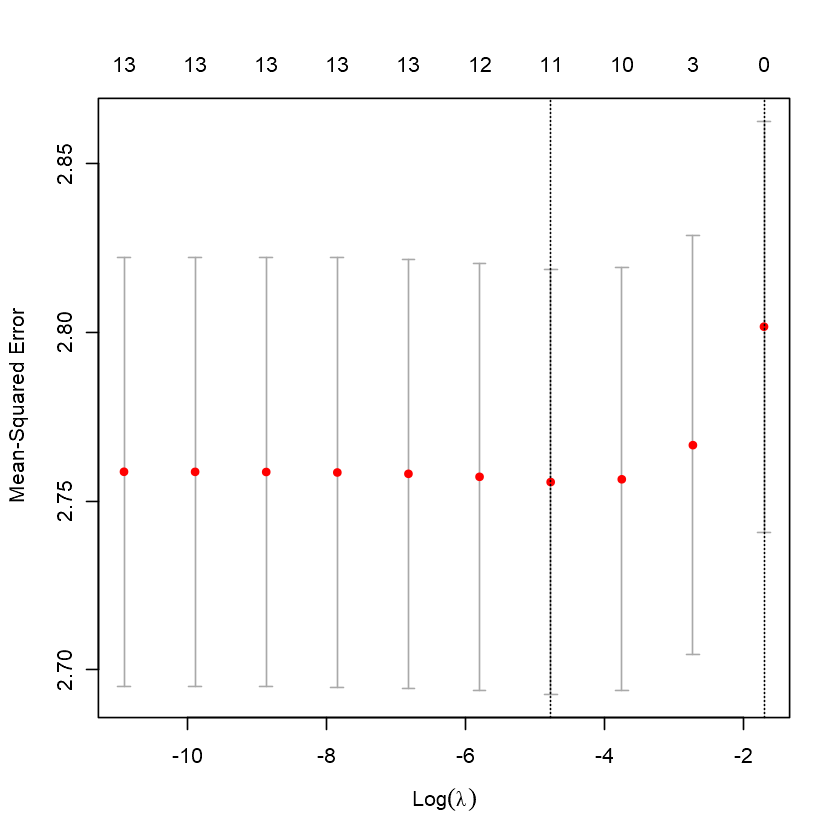

[1] 86

[1] 2.669754

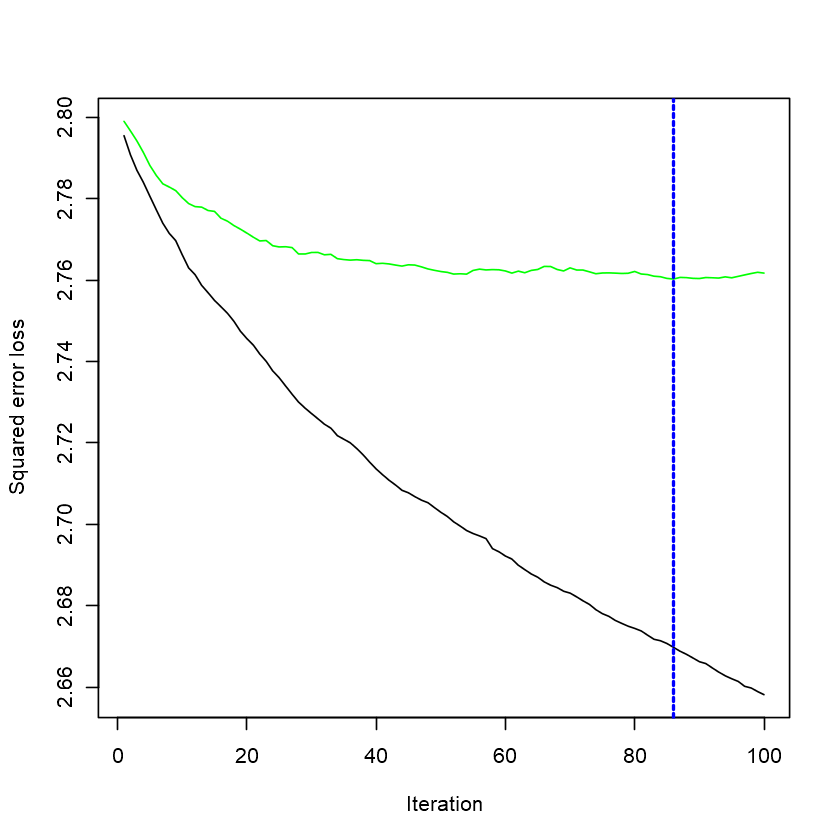

[1] 51

[1] 2.67231

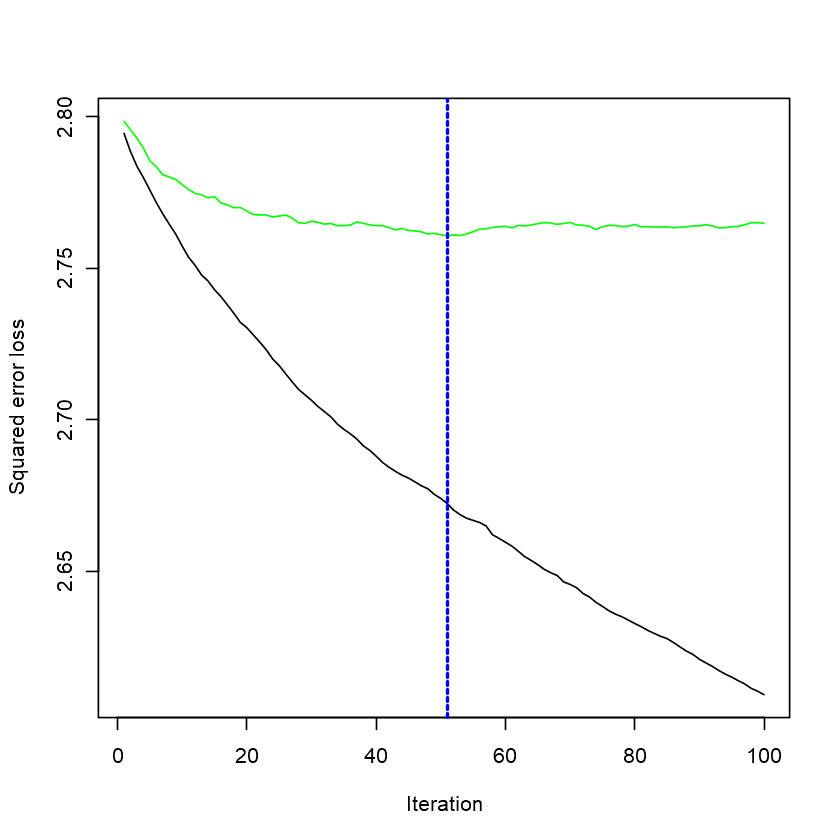

[1] 53

[1] 2.660613

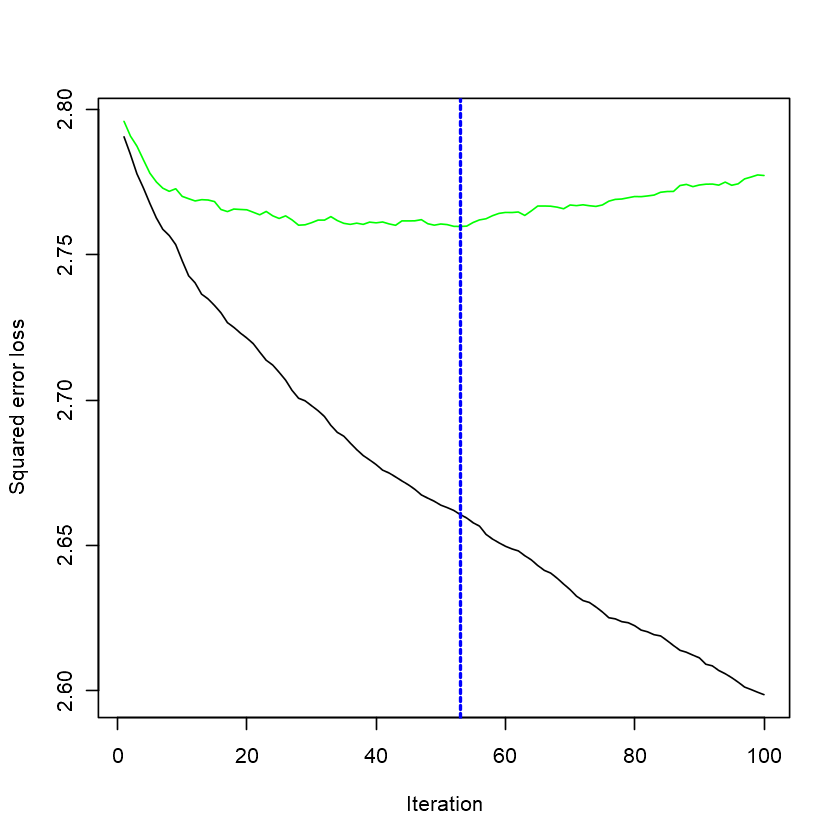

[1] 29

[1] 2.667716

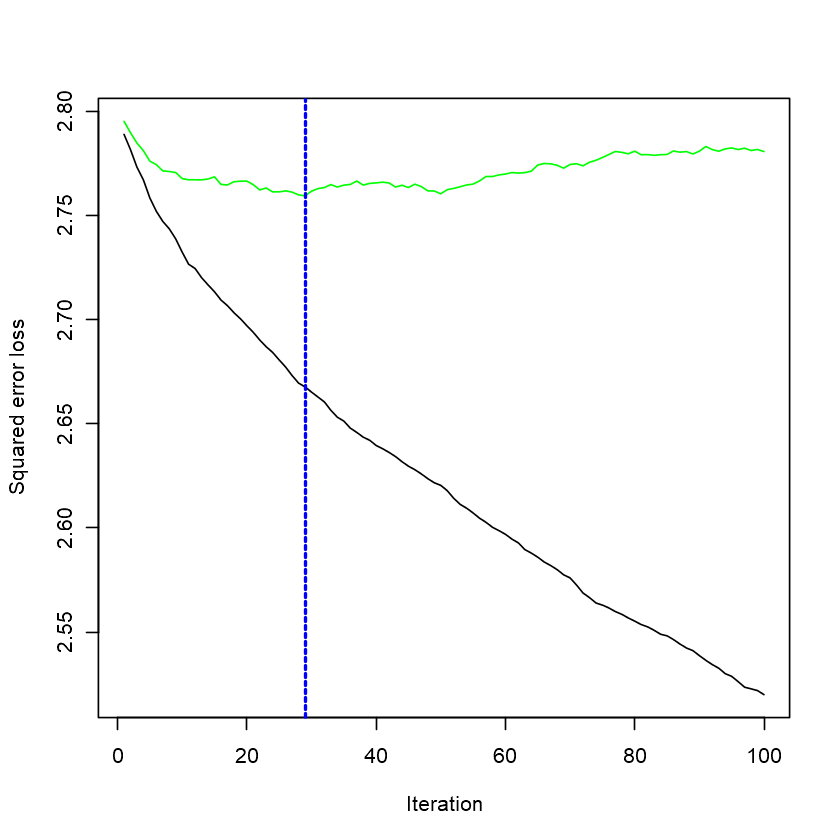

[1] 7

[1] 2.732492

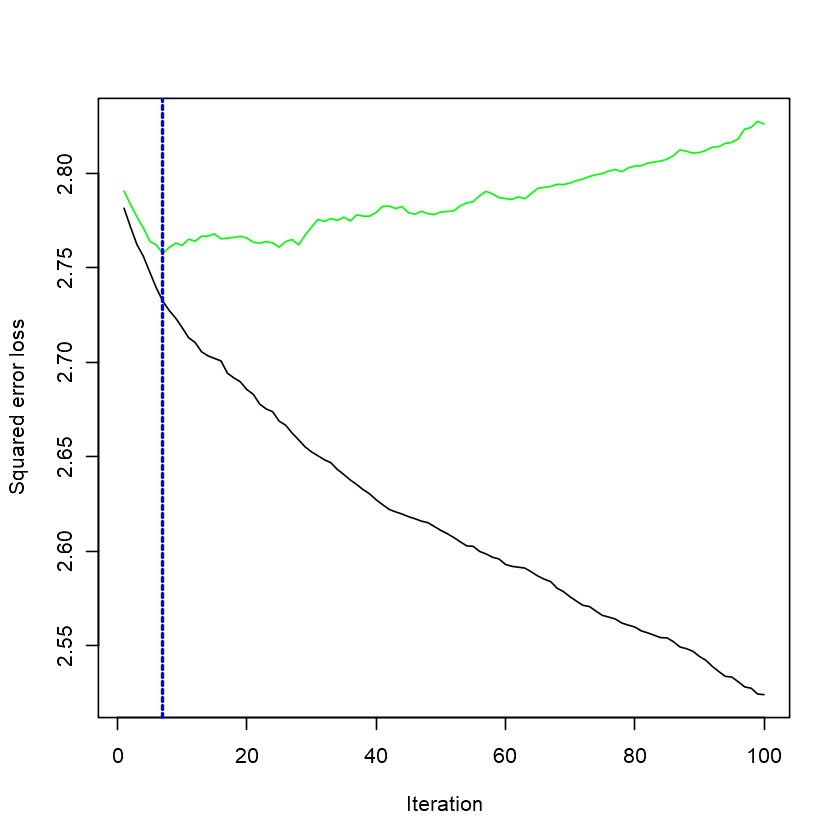

[1] 7

[1] 2.713381

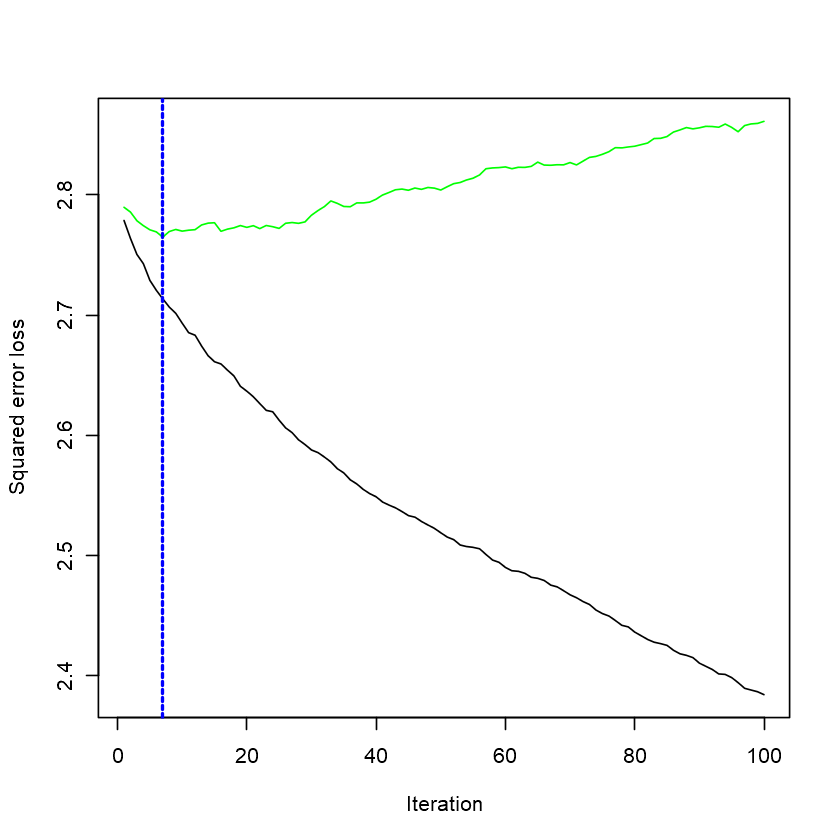

[1] 56

[1] 0.2389309

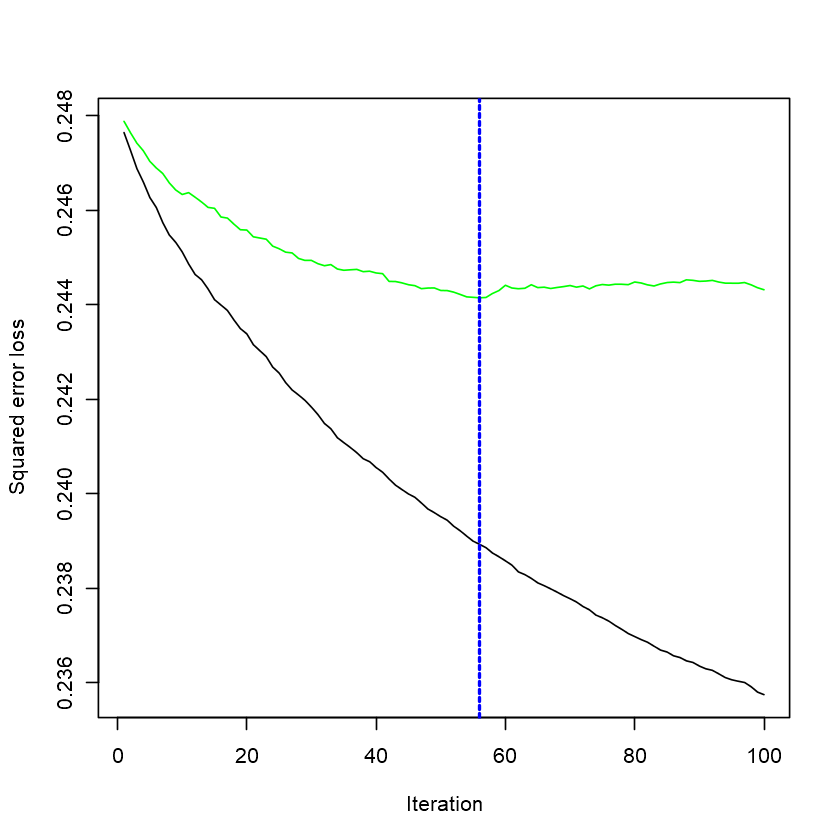

[1] 49

[1] 0.2366091

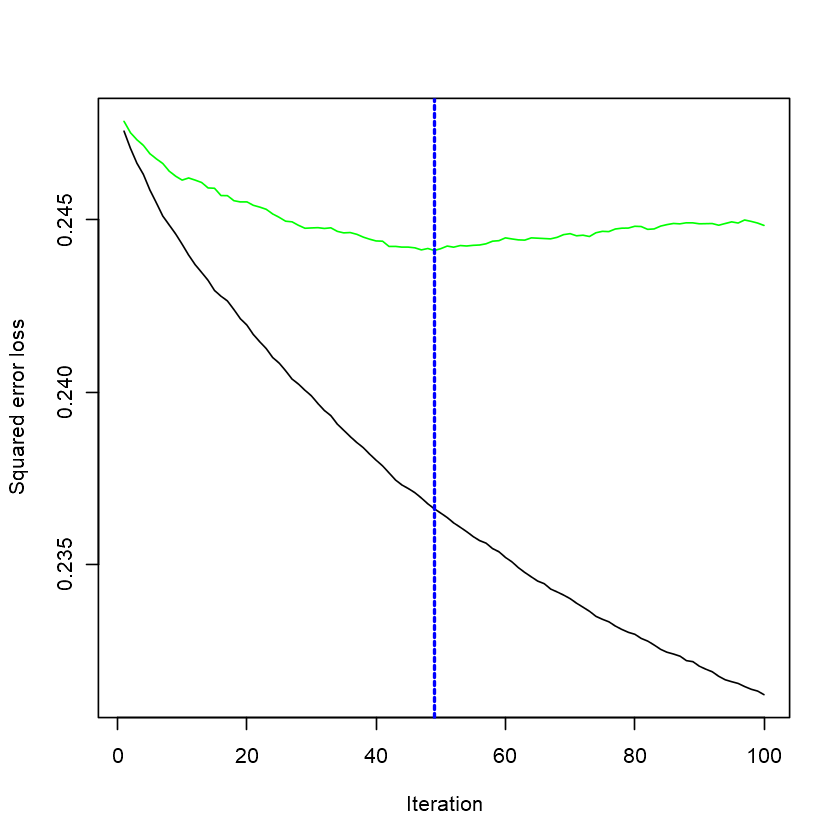

[1] 30

[1] 0.2388965

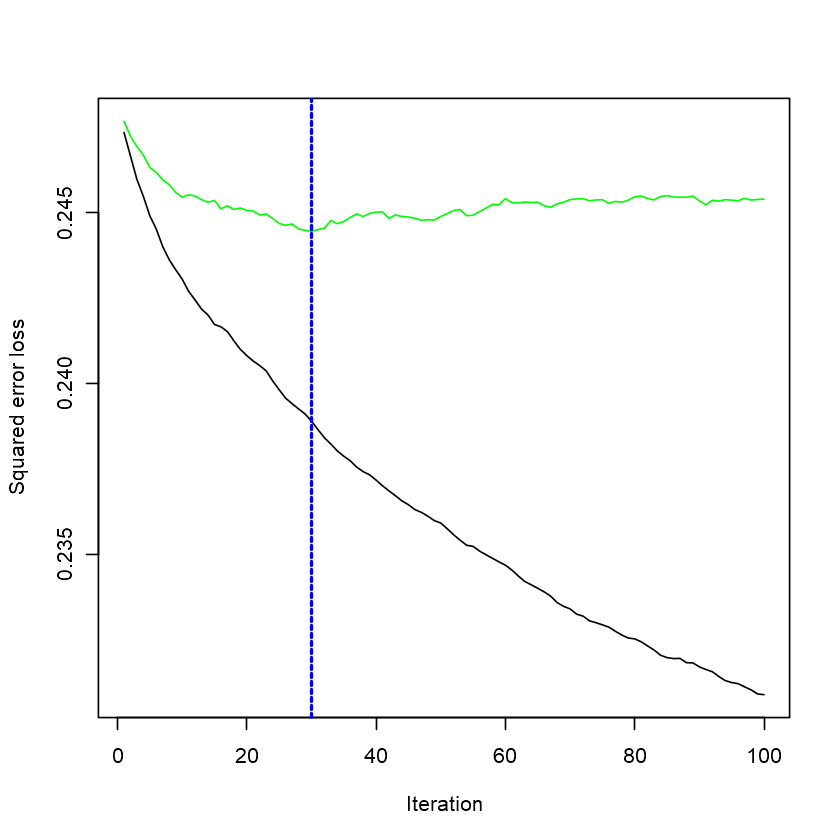

[1] 29

[1] 0.2362631

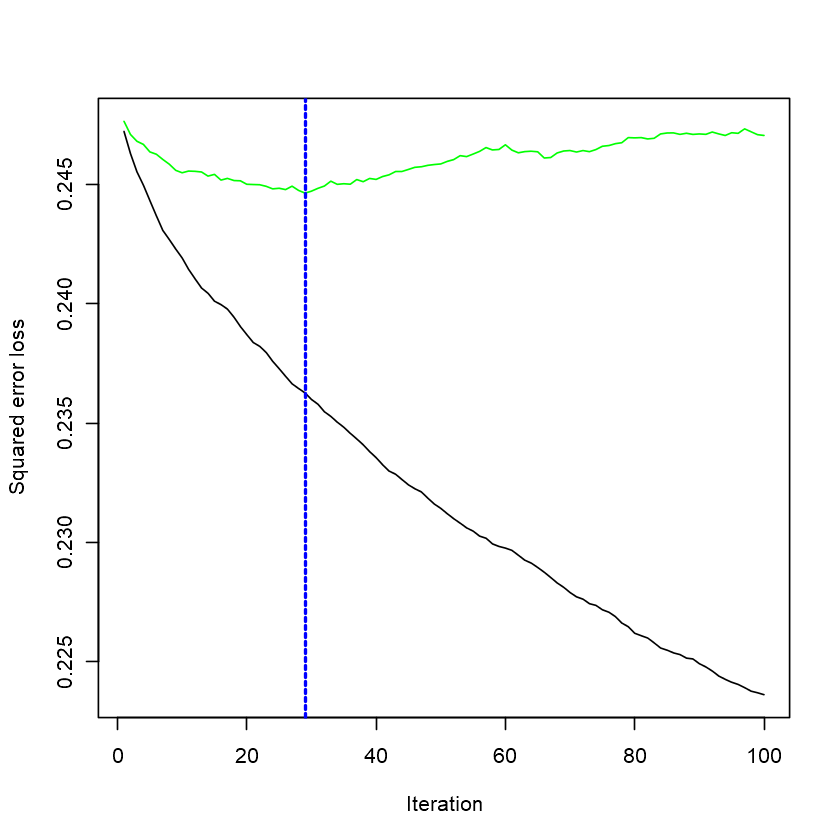

[1] 17

[1] 0.2393881

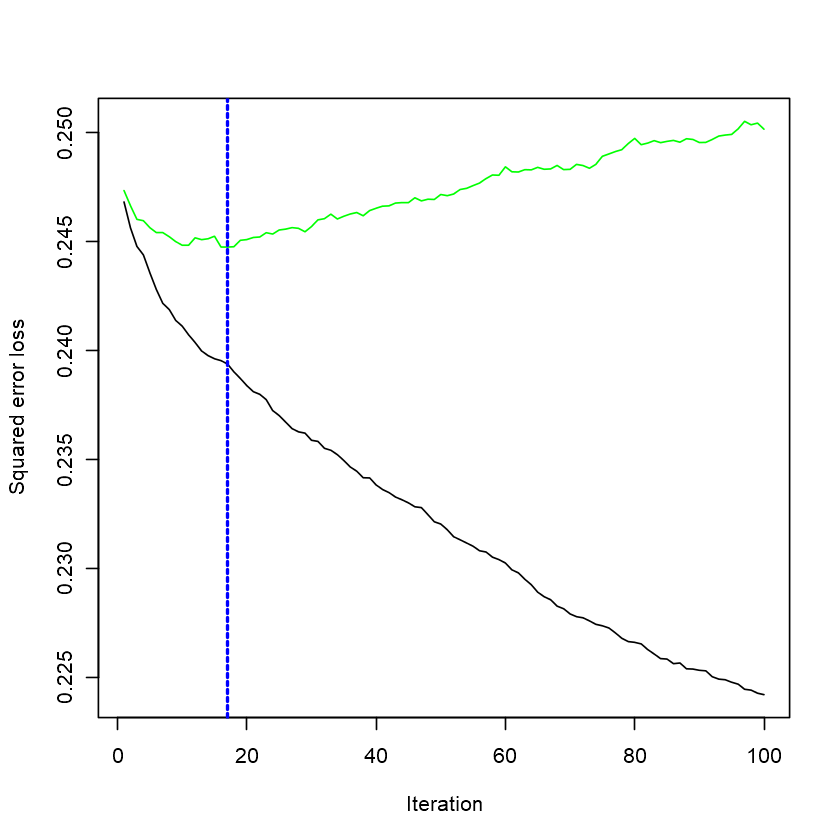

[1] 10

[1] 0.239177

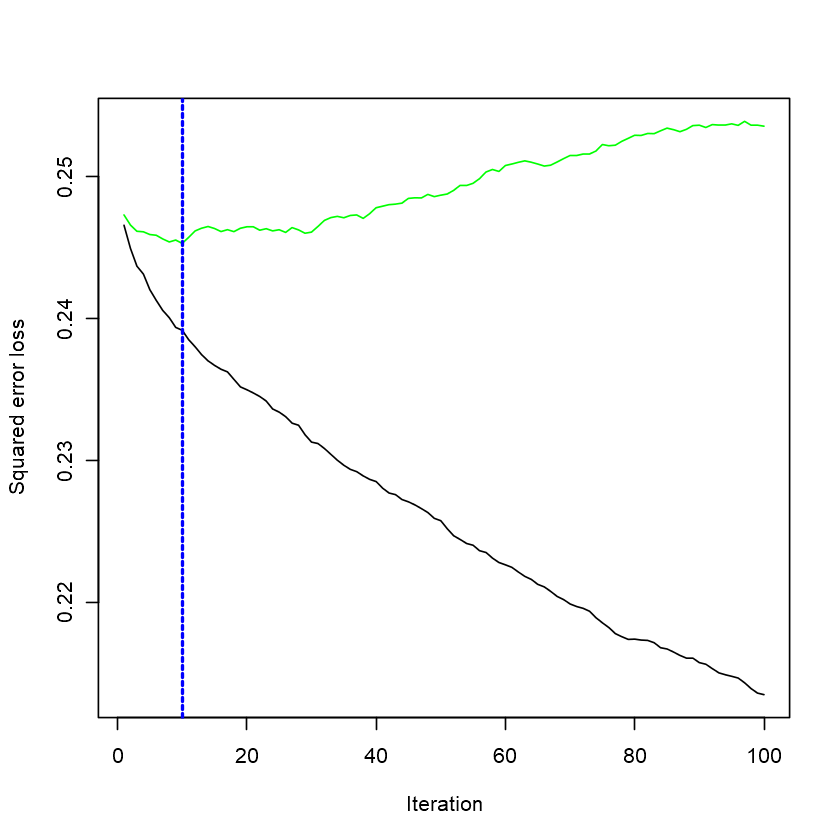

In [1]:
library(dplyr)
library(glmnet)
library("data.table")
matches <-data.table(read.csv("C:\\Users\\Linktera\\Desktop\\582kupon20191215\\matches.csv", header = TRUE))
stats <-data.table(read.csv("C:\\Users\\Linktera\\Desktop\\582kupon20191215\\stats.csv", header = TRUE))
match_detail<-function(input_match_id){
  

  temp<-subset(matches,matches$match_id==input_match_id)
  
  home_matches<-subset(matches,matches$match_hometeam_id==temp$match_hometeam_id&temp$epoch>matches$epoch)
  away_matches<-subset(matches,matches$match_awayteam_id==temp$match_awayteam_id&temp$epoch>matches$epoch)
  
  
  
  home_matches<-home_matches%>%arrange(desc(epoch))%>%head(5)
  away_matches<-away_matches%>%arrange(desc(epoch))%>%head(5)
  
  
  home_stats<-stats%>%filter(match_id%in%home_matches$match_id)%>%summarise(home_attigi_GoalAttempts=mean(home_GoalAttempts),
                                                                                home_attigi_ShotsonGoal=mean(home_ShotsonGoal),
                                                                                home_yedigi_GoalAttempts=mean(away_GoalAttempts),
                                                                                home_yedigi_ShotsonGoal=mean(away_ShotsonGoal),
                                                                                home_CornerKicks=mean(home_CornerKicks),
                                                                                home_keeper_rate=sum(home_GoalkeeperSaves)/sum(away_ShotsonGoal)
  )
    away_stats<-stats%>%filter(match_id%in%away_matches$match_id)%>%summarise(away_attigi_GoalAttempts=mean(away_GoalAttempts),
                                                                                away_attigi_ShotsonGoal=mean(away_ShotsonGoal),
                                                                                away_yedigi_GoalAttempts=mean(home_GoalAttempts),
                                                                                away_yedigi_ShotsonGoal=mean(home_ShotsonGoal),
                                                                                away_CornerKicks=mean(away_CornerKicks),
                                                                                away_keeper_rate=sum(away_GoalkeeperSaves)/sum(home_ShotsonGoal)
  )
  
 
  
  result<-data.frame(matrix(ncol=1))                                                                              
  result[,1]=input_match_id
  result[,2:7]=home_stats
  result[,8:13]=away_stats
  names(result)[1]="match_id"
  
  #result<-na.omit(result)
  return(result)
  
}


full_set<-data.frame(matrix(ncol=13))   
for(i in 1:length(matches$match_id)){
  full_set[i,]<-match_detail(matches$match_id[i])
  }


#full_set_yedek<-full_set
#full_set<-full_set_yedek

colnames(full_set)<-colnames(match_detail(matches$match_id[i]))
full_set<-na.omit(full_set)

full_set<-merge(matches[match_status=='Finished',c("match_awayteam_id", "match_hometeam_id","match_id" ,
                        "epoch","match_hometeam_score" , "match_awayteam_score","league_id")],full_set,by='match_id')



full_set$total_goal = full_set$match_hometeam_score+ full_set$match_awayteam_score


full_set<-na.omit(full_set)



full_set$quality_diff<-full_set$home_attigi_GoalAttempts/full_set$home_yedigi_GoalAttempts-full_set$away_attigi_GoalAttempts/full_set$away_yedigi_GoalAttempts

full_set$alt_ust=as.numeric(full_set$total_goal>2.5)
set.seed(3)
train <- full_set %>% sample_frac(.70)
test  <- anti_join(full_set, train, by = 'match_id')

x<-as.matrix(train[,c('quality_diff','home_attigi_GoalAttempts','home_attigi_ShotsonGoal','home_yedigi_GoalAttempts','home_yedigi_ShotsonGoal','home_CornerKicks','home_keeper_rate','away_attigi_GoalAttempts','away_attigi_ShotsonGoal','away_yedigi_GoalAttempts','away_yedigi_ShotsonGoal','away_CornerKicks','away_keeper_rate')])
y<-train$total_goal
y_altust<-train$alt_ust

testx<-as.matrix(test[,c('quality_diff','home_attigi_GoalAttempts','home_attigi_ShotsonGoal','home_yedigi_GoalAttempts','home_yedigi_ShotsonGoal','home_CornerKicks','home_keeper_rate','away_attigi_GoalAttempts','away_attigi_ShotsonGoal','away_yedigi_GoalAttempts','away_yedigi_ShotsonGoal','away_CornerKicks','away_keeper_rate')])
testy <-test$total_goal
testy_altust<-test$alt_ust

#glm score

set.seed(123)
cv<-cv.glmnet(x=x,y=y,alpha=1,nlambda = 10)
glm<-glmnet(x,y,lambda = cv$lambda.1se)

pred<-predict(glm,testx,s=cv$lambda.1se,type="response")
mse<-mean((testy-pred)^2)#2.768556
glm<-glmnet(x,y,lambda = cv$lambda.min)
pred<-predict(glm,testx,s=cv$lambda.min,type="response")
mse<-mean((testy-pred)^2)#2.735427
plot(cv)


set.seed(123)
cv<-cv.glmnet(x=x,y=y,alpha=1,nlambda = 100)
glm<-glmnet(x,y,lambda = cv$lambda.1se)
pred<-predict(glm,testx,s=cv$lambda.1se,type="response")
mse<-mean((testy-pred)^2)#2.768556
mse
glm<-glmnet(x,y,lambda = cv$lambda.min)
pred<-predict(glm,testx,s=cv$lambda.min,type="response")
mse<-mean((testy-pred)^2)#2.73531
mse

##as we can see from error terms glm performance is not very responsive to the number of nlambda and choice of lambda.

#glm alt ust


set.seed(123)
cv<-cv.glmnet(x=x,y=y_altust,alpha=1,nlambda = 10)
glm<-glmnet(x,y_altust,lambda = cv$lambda.1se)
pred_altust<-predict(glm,testx,s=cv$lambda.1se,type="response")
mean(as.numeric(as.numeric(pred_altust>mean(y_altust))==testy_altust))#0.5387477

glm<-glmnet(x,y_altust,lambda = cv$lambda.min)
pred_altust<-predict(glm,testx,s=cv$lambda.min,type="response")
mean(as.numeric(as.numeric(pred_altust>mean(y_altust))==testy_altust))#0.5523869

set.seed(123)
cv<-cv.glmnet(x=x,y=y_altust,alpha=1,nlambda = 100)
glm<-glmnet(x,y_altust,lambda = cv$lambda.1se)
pred_altust<-predict(glm,testx,s=cv$lambda.1se,type="response")
mean(as.numeric(as.numeric(pred_altust>mean(y_altust))==testy_altust))#0.5418475

glm<-glmnet(x,y_altust,lambda = cv$lambda.min)
pred_altust<-predict(glm,testx,s=cv$lambda.min,type="response")
mean(as.numeric(as.numeric(pred_altust>mean(y_altust))==testy_altust))#0.5486671

##the choice of lambda is more important when we dealing with score limit. 
##however the overall performance is not good since model performance is slightly better than random selection 

#decision tree score

#install.packages('rpart.plot')
library(rpart)
library(rpart.plot)

dt<-rpart(y~x, cp = 0.001,minbucket = 50,xval = 10)

mean((y-predict(dt))^2)#2.594344

dt<-rpart(y~x, cp = 0.003,minbucket = 100,xval = 10)

mean((y-predict(dt))^2)#2.764024

dt<-rpart(y~x, cp = 0.001,minbucket = 10,xval = 10)

mean((y-predict(dt))^2)#2.02643

dt<-rpart(y~x, cp = 0.01,minbucket = 50,xval = 10)

mean((y-predict(dt))^2)#2.795087



#decision tree altust

dt<-rpart(y_altust~x, cp = 0.003,minbucket = 100)

pred_altust<-predict(dt)
mean(as.numeric(as.numeric(pred_altust>mean(y_altust))==y_altust))#0.579479


dt<-rpart(y_altust~x, cp = 0.001,minbucket = 100)

pred_altust<-predict(dt)
mean(as.numeric(as.numeric(pred_altust>mean(y_altust))==y_altust))#0.6004785

dt<-rpart(y_altust~x, cp = 0.001,minbucket = 10)

pred_altust<-predict(dt)
mean(as.numeric(as.numeric(pred_altust>mean(y_altust))==y_altust))#0.7506645

dt<-rpart(y_altust~x, cp = 0.01,minbucket = 100)

pred_altust<-predict(dt)
mean(as.numeric(as.numeric(pred_altust>mean(y_altust))==y_altust))#0.5486443

#in decision tree performance of model increases for training dataset as we let model gain more complexity, But it isprobably  caused by overfitting.

#random forest score

library(randomForest)
#install.packages("randomForest")

rf1<-randomForest(x,y,ntree=500,nodesize=5,mtry=1)
rf2<-randomForest(x,y,ntree=500,nodesize=5,mtry=2)
rf3<-randomForest(x,y,ntree=500,nodesize=5,mtry=3)
rf4<-randomForest(x,y,ntree=500,nodesize=5,mtry=4)
rf5<-randomForest(x,y,ntree=500,nodesize=5,mtry=5)
rf6<-randomForest(x,y,ntree=500,nodesize=5,mtry=6)
rf7<-randomForest(x,y,ntree=500,nodesize=5,mtry=7)
rf8<-randomForest(x,y,ntree=500,nodesize=5,mtry=8)


mean((testy-predict(rf1,testx))^2)#2.749466
mean((testy-predict(rf2,testx))^2)#2.762367
mean((testy-predict(rf3,testx))^2)#2.766337
mean((testy-predict(rf4,testx))^2)#2.784455
mean((testy-predict(rf5,testx))^2)#2.773671
mean((testy-predict(rf6,testx))^2)#2.790298
mean((testy-predict(rf7,testx))^2)#2.780841
mean((testy-predict(rf8,testx))^2)#2.789218

#random forests performance is not much responsive to mtry parameter

#random forest altust
rf1<-randomForest(x,as.factor(y_altust),ntree=500,nodesize=5,mtry=1)
rf2<-randomForest(x,as.factor(y_altust),ntree=500,nodesize=5,mtry=2)
rf3<-randomForest(x,as.factor(y_altust),ntree=500,nodesize=5,mtry=3)
rf4<-randomForest(x,as.factor(y_altust),ntree=500,nodesize=5,mtry=4)
rf5<-randomForest(x,as.factor(y_altust),ntree=500,nodesize=5,mtry=5)
rf6<-randomForest(x,as.factor(y_altust),ntree=500,nodesize=5,mtry=6)
rf7<-randomForest(x,as.factor(y_altust),ntree=500,nodesize=5,mtry=7)
rf8<-randomForest(x,as.factor(y_altust),ntree=500,nodesize=5,mtry=8)

mean(as.numeric(as.numeric(predict(rf1,testx))==testy_altust))#0.2138872
mean(as.numeric(as.numeric(predict(rf2,testx))==testy_altust))#0.2039678
mean(as.numeric(as.numeric(predict(rf3,testx))==testy_altust))#0.2045877
mean(as.numeric(as.numeric(predict(rf4,testx))==testy_altust))#0.2021079
mean(as.numeric(as.numeric(predict(rf5,testx))==testy_altust))#0.2058277
mean(as.numeric(as.numeric(predict(rf6,testx))==testy_altust))#0.2039678
mean(as.numeric(as.numeric(predict(rf7,testx))==testy_altust))#0.2058277
mean(as.numeric(as.numeric(predict(rf8,testx))==testy_altust))#0.2120273

#random forests 

#gbm score
library(gbm)


train_gbm<-train[,c('quality_diff','home_attigi_GoalAttempts','home_attigi_ShotsonGoal','home_yedigi_GoalAttempts','home_yedigi_ShotsonGoal','home_CornerKicks','home_keeper_rate','away_attigi_GoalAttempts','away_attigi_ShotsonGoal','away_yedigi_GoalAttempts','away_yedigi_ShotsonGoal','away_CornerKicks','away_keeper_rate','total_goal')]



set.seed(123)
gbm_fit<-gbm(data=train_gbm,formula=total_goal~.,distribution = "gaussian", 
             n.trees = 100,interaction.depth = 2,shrinkage =0.05,cv.folds = 10)
gbm.perf(gbm_fit, method = "cv")
gbm_fit$train.error[gbm.perf(gbm_fit, method = "cv")]#2.694243

set.seed(123)
gbm_fit<-gbm(data=train_gbm,formula=total_goal~.,distribution = "gaussian", 
             n.trees = 100,interaction.depth = 3,shrinkage =0.05,cv.folds = 10)
gbm.perf(gbm_fit, method = "cv")
gbm_fit$train.error[gbm.perf(gbm_fit, method = "cv")]# 2.696326

set.seed(123)
gbm_fit<-gbm(data=train_gbm,formula=total_goal~.,distribution = "gaussian", 
             n.trees = 100,interaction.depth = 2,shrinkage =0.1,cv.folds = 10)
gbm.perf(gbm_fit, method = "cv")
gbm_fit$train.error[gbm.perf(gbm_fit, method = "cv")]#2.713169

set.seed(123)
gbm_fit<-gbm(data=train_gbm,formula=total_goal~.,distribution = "gaussian", 
             n.trees = 100,interaction.depth = 3,shrinkage =0.1,cv.folds = 10)
gbm.perf(gbm_fit, method = "cv")
gbm_fit$train.error[gbm.perf(gbm_fit, method = "cv")]#2.713187

set.seed(123)
gbm_fit<-gbm(data=train_gbm,formula=total_goal~.,distribution = "gaussian", 
             n.trees = 100,interaction.depth = 2,shrinkage =0.2,cv.folds = 10)
gbm.perf(gbm_fit, method = "cv")
gbm_fit$train.error[gbm.perf(gbm_fit, method = "cv")]#2.736052

set.seed(123)
gbm_fit<-gbm(data=train_gbm,formula=total_goal~.,distribution = "gaussian", 
             n.trees = 100,interaction.depth = 3,shrinkage =0.2,cv.folds = 10)
gbm.perf(gbm_fit, method = "cv")
gbm_fit$train.error[gbm.perf(gbm_fit, method = "cv")]#2.725672


#gbm altust
train_gbm_altust<-train[,c('quality_diff','home_attigi_GoalAttempts','home_attigi_ShotsonGoal','home_yedigi_GoalAttempts','home_yedigi_ShotsonGoal','home_CornerKicks','home_keeper_rate','away_attigi_GoalAttempts','away_attigi_ShotsonGoal','away_yedigi_GoalAttempts','away_yedigi_ShotsonGoal','away_CornerKicks','away_keeper_rate','alt_ust')]

set.seed(123)
gbm_fit<-gbm(data=train_gbm_altust,formula=alt_ust~.,distribution = "gaussian", 
             n.trees = 100,interaction.depth = 2,shrinkage =0.05,cv.folds = 10)
gbm.perf(gbm_fit, method = "cv")
gbm_fit$train.error[gbm.perf(gbm_fit, method = "cv")]# 0.236258

set.seed(123)
gbm_fit<-gbm(data=train_gbm_altust,formula=alt_ust~.,distribution = "gaussian", 
             n.trees = 100,interaction.depth = 3,shrinkage =0.05,cv.folds = 10)
gbm.perf(gbm_fit, method = "cv")
gbm_fit$train.error[gbm.perf(gbm_fit, method = "cv")]# 0.2327446

set.seed(123)
gbm_fit<-gbm(data=train_gbm_altust,formula=alt_ust~.,distribution = "gaussian", 
             n.trees = 100,interaction.depth = 2,shrinkage =0.1,cv.folds = 10)
gbm.perf(gbm_fit, method = "cv")
gbm_fit$train.error[gbm.perf(gbm_fit, method = "cv")]#0.2388357

set.seed(123)
gbm_fit<-gbm(data=train_gbm_altust,formula=alt_ust~.,distribution = "gaussian", 
             n.trees = 100,interaction.depth = 3,shrinkage =0.1,cv.folds = 10)
gbm.perf(gbm_fit, method = "cv")
gbm_fit$train.error[gbm.perf(gbm_fit, method = "cv")]#0.2376832

set.seed(123)
gbm_fit<-gbm(data=train_gbm_altust,formula=alt_ust~.,distribution = "gaussian", 
             n.trees = 100,interaction.depth = 2,shrinkage =0.2,cv.folds = 10)
gbm.perf(gbm_fit, method = "cv")
gbm_fit$train.error[gbm.perf(gbm_fit, method = "cv")]#0.2412114

set.seed(123)
gbm_fit<-gbm(data=train_gbm_altust,formula=alt_ust~.,distribution = "gaussian", 
             n.trees = 100,interaction.depth = 3,shrinkage =0.2,cv.folds = 10)
gbm.perf(gbm_fit, method = "cv")
gbm_fit$train.error[gbm.perf(gbm_fit, method = "cv")]#0.2407693


##the error rates of gbm looks promising for score limit prediction. 
##performance also is not responsive to parameters also for both cases





